# Time Series stock price forcasting with LSTM

## Loading the required libraries

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import CSVLogger
from datetime import datetime
%matplotlib inline

Using TensorFlow backend.


## Loading and exploring the stock data

In [2]:
df = pd.read_csv('DJIA_table.csv', parse_dates=['Date'], index_col=['Date'] )

# A quick check on dataframe structure
print(df.info())
print(df.head(3))
print(df.tail(3))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1989 entries, 2016-07-01 to 2008-08-08
Data columns (total 6 columns):
Open         1989 non-null float64
High         1989 non-null float64
Low          1989 non-null float64
Close        1989 non-null float64
Volume       1989 non-null int64
Adj Close    1989 non-null float64
dtypes: float64(5), int64(1)
memory usage: 108.8 KB
None
                    Open          High           Low         Close     Volume  \
Date                                                                            
2016-07-01  17924.240234  18002.380859  17916.910156  17949.369141   82160000   
2016-06-30  17712.759766  17930.609375  17711.800781  17929.990234  133030000   
2016-06-29  17456.019531  17704.509766  17456.019531  17694.679688  106380000   

               Adj Close  
Date                      
2016-07-01  17949.369141  
2016-06-30  17929.990234  
2016-06-29  17694.679688  
                    Open          High           Low         Close    

In [3]:
# Sort the data based on date in ascendating order i.e oldest date first
df = df.sort_index(ascending=True)

In [4]:
df.astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1989 entries, 2008-08-08 to 2016-07-01
Data columns (total 6 columns):
Open         1989 non-null float64
High         1989 non-null float64
Low          1989 non-null float64
Close        1989 non-null float64
Volume       1989 non-null int64
Adj Close    1989 non-null float64
dtypes: float64(5), int64(1)
memory usage: 108.8 KB


In [5]:
# Re-arrange the columns order
#columns=['Open', 'High', 'Low', 'Volume','Close']
# We will only use 'Volume' and 'Close' as the features
columns=['Volume','Close']
df = df[columns]

In [6]:
# Re-sample to weeky data
df = df.resample('1W').mean()
print(df.head(3))
print(df.tail(3))

                 Volume         Close
Date                                 
2008-08-10  212830000.0  11734.320312
2008-08-17  182832000.0  11646.721875
2008-08-24  148312000.0  11460.727734
                 Volume         Close
Date                                 
2016-06-19  126038000.0  17691.146094
2016-06-26  122204000.0  17765.450000
2016-07-03  114500000.0  17624.800000


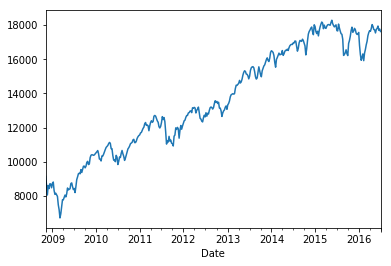

In [7]:
df.Close.tail(400).plot()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 413 entries, 2008-08-10 to 2016-07-03
Freq: W-SUN
Data columns (total 2 columns):
Volume    413 non-null float64
Close     413 non-null float64
dtypes: float64(2)
memory usage: 9.7 KB


## Convert time series data into supervised data
The goal of this mini project is to predict the next day's 'Close' price of the stock.

We will re-arrange the dataframe so that the next day's 'Close' price will become the label for today date

In [9]:
# Using the next day 'Close' price as today label and we will use 'Y' as the column name
df['Y'] = df['Close'].shift(-1)

In [10]:
# A quick check on the dataframe after data re-arrangement
print(df.head(5))
print(df.tail(5))
print(df.shape)


                 Volume         Close             Y
Date                                               
2008-08-10  212830000.0  11734.320312  11646.721875
2008-08-17  182832000.0  11646.721875  11460.727734
2008-08-24  148312000.0  11460.727734  11512.153906
2008-08-31  141010000.0  11512.153906  11364.747559
2008-09-07  194710000.0  11364.747559  11373.218164
                 Volume         Close             Y
Date                                               
2016-06-05   95937500.0  17805.622559  17942.837891
2016-06-12   76422000.0  17942.837891  17691.146094
2016-06-19  126038000.0  17691.146094  17765.450000
2016-06-26  122204000.0  17765.450000  17624.800000
2016-07-03  114500000.0  17624.800000           NaN
(413, 3)


In [11]:
indicators = pd.read_csv('processed_indicators.csv', parse_dates=['Date'], index_col=['Date'] )

# Our index data start from 2008-08-10
indicators =indicators[indicators.index > '2008-08-09']

#indicators.index
# A quick check on dataframe structure
print(indicators.info())
print(indicators.head(3))
print(indicators.tail(3))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 413 entries, 2008-08-10 to 2016-07-03
Data columns (total 4 columns):
RetailSales    413 non-null int64
CPI            413 non-null float64
NFP            413 non-null int64
IPI            413 non-null float64
dtypes: float64(2), int64(2)
memory usage: 16.1 KB
None
            RetailSales    CPI  NFP     IPI
Date                                       
2008-08-10        -5805  0.187 -450 -4.3436
2008-08-17        -5805  0.187 -450 -4.3436
2008-08-24        -5805  0.187 -450 -4.3436
            RetailSales    CPI  NFP     IPI
Date                                       
2016-06-19         -745  0.056  291  0.0924
2016-06-26         -745  0.056  291  0.0924
2016-07-03         -745  0.056  291  0.0924


In [12]:
# Merge the 2 data frames
#df = pd.concat([df, indicators] , axis=0, join_axes=[df.index])
df = pd.merge(df, indicators, how='inner', left_index=True, right_index=True)
df.tail(5)

,Volume,Close,Y,RetailSales,CPI,NFP,IPI
Date,,,,,,,
2016-06-05,95937500.0,17805.622559,17942.837891,-745,0.056,291,0.0924
2016-06-12,76422000.0,17942.837891,17691.146094,-745,0.056,291,0.0924
2016-06-19,126038000.0,17691.146094,17765.450000,-745,0.056,291,0.0924
2016-06-26,122204000.0,17765.450000,17624.800000,-745,0.056,291,0.0924
2016-07-03,114500000.0,17624.800000,NaN,-745,0.056,291,0.0924


In [13]:
# Since we are shifting the data upward, the last row of the dataframe is containing 'Nan' value for Y
# We will remove this 
df = df[:-1]
print(df.tail(5))

                 Volume         Close             Y  RetailSales    CPI  NFP  \
Date                                                                           
2016-05-29   79116000.0  17750.400000  17805.622559         4504  0.480  297   
2016-06-05   95937500.0  17805.622559  17942.837891         -745  0.056  291   
2016-06-12   76422000.0  17942.837891  17691.146094         -745  0.056  291   
2016-06-19  126038000.0  17691.146094  17765.450000         -745  0.056  291   
2016-06-26  122204000.0  17765.450000  17624.800000         -745  0.056  291   

               IPI  
Date                
2016-05-29  0.3697  
2016-06-05  0.0924  
2016-06-12  0.0924  
2016-06-19  0.0924  
2016-06-26  0.0924  


In [14]:
df = df[['CPI', 'IPI', 'NFP', 'RetailSales', 'Volume', 'Close', 'Y']]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 412 entries, 2008-08-10 to 2016-06-26
Freq: W-SUN
Data columns (total 7 columns):
CPI            412 non-null float64
IPI            412 non-null float64
NFP            412 non-null int64
RetailSales    412 non-null int64
Volume         412 non-null float64
Close          412 non-null float64
Y              412 non-null float64
dtypes: float64(5), int64(2)
memory usage: 25.8 KB


## Convert to stationary time series

In [15]:
# Adding a diff column for the prediction Close price (Y) to convert into stationary data
df['Y-diff'] = df['Y'] - df['Close']

# The diff value is the different of Y value from previous day so we need to shift the data to reflect this
#df['Y-diff'] = df['Y-diff'].shift(1)

# Fill the nan cell with 0 value. The first row will be 0
df.fillna(value=0, axis=1, inplace=True)

In [16]:
print(df.head(5))
print(df.tail(5))

              CPI     IPI  NFP  RetailSales       Volume         Close  \
Date                                                                     
2008-08-10  0.187 -4.3436 -450        -5805  212830000.0  11734.320312   
2008-08-17  0.187 -4.3436 -450        -5805  182832000.0  11646.721875   
2008-08-24  0.187 -4.3436 -450        -5805  148312000.0  11460.727734   
2008-08-31  0.187 -4.3436 -450        -5805  141010000.0  11512.153906   
2008-09-07 -1.882  0.9123 -474       -13383  194710000.0  11364.747559   

                       Y      Y-diff  
Date                                  
2008-08-10  11646.721875  -87.598437  
2008-08-17  11460.727734 -185.994141  
2008-08-24  11512.153906   51.426172  
2008-08-31  11364.747559 -147.406348  
2008-09-07  11373.218164    8.470605  
              CPI     IPI  NFP  RetailSales       Volume         Close  \
Date                                                                     
2016-05-29  0.480  0.3697  297         4504   79116000.0  17

In [17]:
# Let's store the original Y values in df_Y
df_Y = df['Y']
df_Y = df_Y
print(df_Y.head(10))
print(df_Y.shape)

# Drop Y from df
df.drop('Y', axis=1, inplace=True)

#base_row = df.iloc[0]
# base_Y = 11782.349609
#print(base_row)

print(df.info())

Date
2008-08-10    11646.721875
2008-08-17    11460.727734
2008-08-24    11512.153906
2008-08-31    11364.747559
2008-09-07    11373.218164
2008-09-14    10998.864063
2008-09-21    10972.043945
2008-09-28    10571.082031
2008-10-05     9138.218164
2008-10-12     9021.598047
Freq: W-SUN, Name: Y, dtype: float64
(412,)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 412 entries, 2008-08-10 to 2016-06-26
Freq: W-SUN
Data columns (total 7 columns):
CPI            412 non-null float64
IPI            412 non-null float64
NFP            412 non-null int64
RetailSales    412 non-null int64
Volume         412 non-null float64
Close          412 non-null float64
Y-diff         412 non-null float64
dtypes: float64(5), int64(2)
memory usage: 25.8 KB
None


In [18]:
print(df.head(5))

              CPI     IPI  NFP  RetailSales       Volume         Close  \
Date                                                                     
2008-08-10  0.187 -4.3436 -450        -5805  212830000.0  11734.320312   
2008-08-17  0.187 -4.3436 -450        -5805  182832000.0  11646.721875   
2008-08-24  0.187 -4.3436 -450        -5805  148312000.0  11460.727734   
2008-08-31  0.187 -4.3436 -450        -5805  141010000.0  11512.153906   
2008-09-07 -1.882  0.9123 -474       -13383  194710000.0  11364.747559   

                Y-diff  
Date                    
2008-08-10  -87.598437  
2008-08-17 -185.994141  
2008-08-24   51.426172  
2008-08-31 -147.406348  
2008-09-07    8.470605  


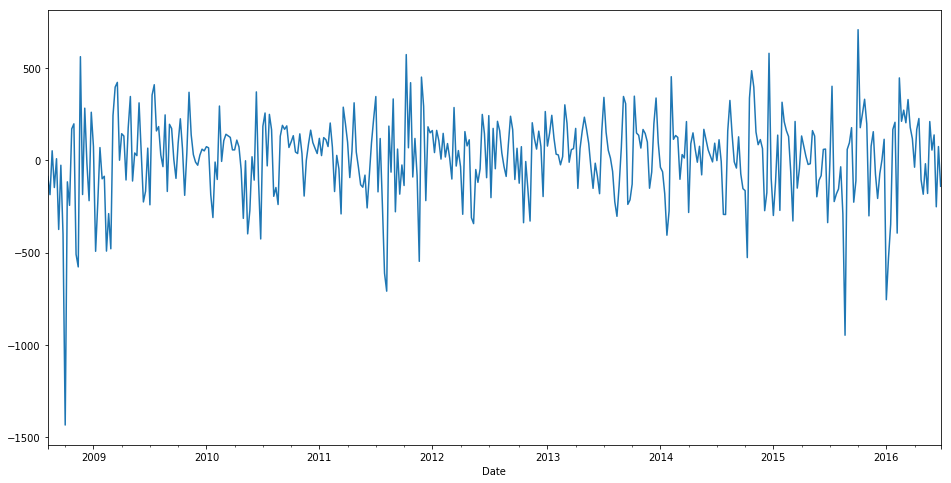

In [19]:
plt.figure(figsize=(16,8))
df['Y-diff'].plot()

In [20]:
# Since we are shifting the data upward, the last row of the dataframe is containing 'Nan' value for Y
print(df.tail(5))

# We will remove this 
df = df[:-1]
print(df.tail(5))

              CPI     IPI  NFP  RetailSales       Volume         Close  \
Date                                                                     
2016-05-29  0.480  0.3697  297         4504   79116000.0  17750.400000   
2016-06-05  0.056  0.0924  291         -745   95937500.0  17805.622559   
2016-06-12  0.056  0.0924  291         -745   76422000.0  17942.837891   
2016-06-19  0.056  0.0924  291         -745  126038000.0  17691.146094   
2016-06-26  0.056  0.0924  291         -745  122204000.0  17765.450000   

                Y-diff  
Date                    
2016-05-29   55.222559  
2016-06-05  137.215332  
2016-06-12 -251.691797  
2016-06-19   74.303906  
2016-06-26 -140.650000  
              CPI     IPI  NFP  RetailSales       Volume         Close  \
Date                                                                     
2016-05-22  0.480  0.3697  297         4504   95668000.0  17540.730078   
2016-05-29  0.480  0.3697  297         4504   79116000.0  17750.400000   
2016-06-05

## Quick visualization of the data correlation

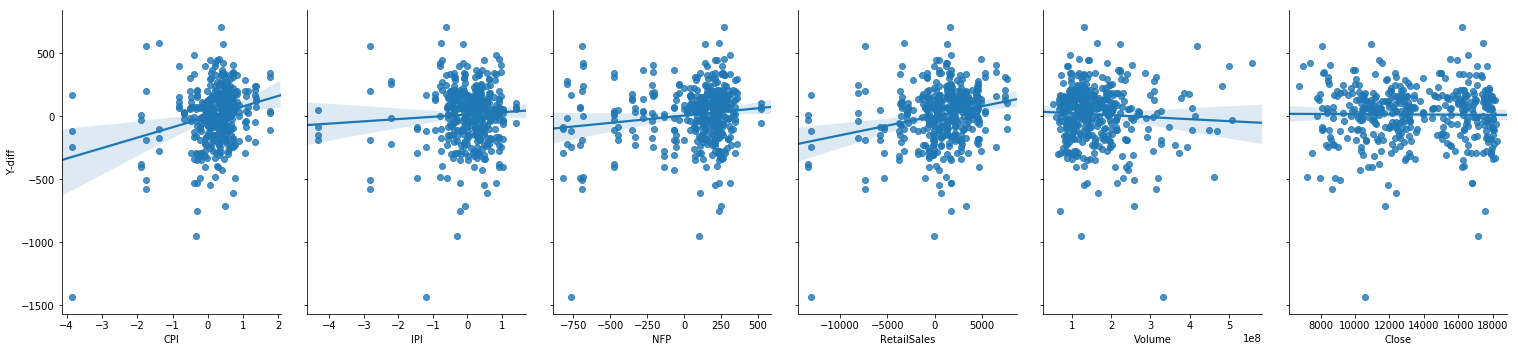

In [45]:
sns.pairplot(df, x_vars=['CPI', 'IPI', 'NFP', 'RetailSales', 'Volume', 'Close'], y_vars='Y-diff', size=5, aspect=0.7, kind='reg')

In [22]:
df.corr()

,CPI,IPI,NFP,RetailSales,Volume,Close,Y-diff
CPI,1.000000e+00,0.206129,0.279003,0.676006,-0.185516,2.309292e-07,0.250751
IPI,2.061289e-01,1.000000,0.479625,0.252768,-0.244861,9.914767e-02,0.061165
NFP,2.790031e-01,0.479625,1.000000,0.359421,-0.742895,6.672516e-01,0.142494
RetailSales,6.760064e-01,0.252768,0.359421,1.000000,-0.175586,6.163655e-02,0.233674
Volume,-1.855161e-01,-0.244861,-0.742895,-0.175586,1.000000,-7.812070e-01,-0.056887
Close,2.309292e-07,0.099148,0.667252,0.061637,-0.781207,1.000000e+00,-0.009739
Y-diff,2.507508e-01,0.061165,0.142494,0.233674,-0.056887,-9.738664e-03,1.000000


In [24]:
# Checking co-efficient of the data
from sklearn.linear_model import LinearRegression

# create X and y
features= df.columns[:-1]
X = df[features]
y = df['Y-diff']

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print(features)
print(linreg.coef_)

Index(['CPI', 'IPI', 'NFP', 'RetailSales', 'Volume', 'Close'], dtype='object')
[  5.11046039e+01  -2.13798930e+01   1.66110185e-01   5.62673309e-03
   5.81905226e-08  -9.29545337e-03]


## Data normalization 
Let's normalize our data for the machine learning algorithms to function better
We will use MinMaxScaler

In [25]:
data = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [26]:
# Split data into train and test scaled_data 
train_size = int(len(scaled_data) * 0.65)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]
print(len(scaled_data), len(train), len(test))
print(scaled_data.shape, train.shape, test.shape)

411 267 144
(411, 7) (267, 7) (144, 7)


In [27]:
# Split data into features X, and lable y
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X)
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

[[ 0.71818182  0.          0.27691166  0.36145958  0.3164547   0.43378838]
 [ 0.71818182  0.          0.27691166  0.36145958  0.25724921  0.42621432]
 [ 0.71818182  0.          0.27691166  0.36145958  0.18911888  0.41013262]
 ..., 
 [ 0.70017825  0.73970383  0.76837416  0.70937276  0.11550577  0.70228779]
 [ 0.70017825  0.73970383  0.76837416  0.70937276  0.13032984  0.70804027]
 [ 0.70017825  0.73970383  0.76837416  0.70937276  0.08847863  0.7378955 ]]
(267, 6) (267,)
(144, 6) (144,)


## Define the LSTM model parameters

In [28]:
# Reshape input data to 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Reshape output to 2D 
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(267, 1, 6) (267, 1) (144, 1, 6) (144, 1)


In [29]:
# Parameters for LSTM model

batchsize=8
epoch=200
optimizer='adam'
neurons=8
now = datetime.now().strftime('%Y%m%d_%H%M')
outfile='logs/loss_%s_batchsize_%s_epoch_%s_neurons_%s_optimizer_%s_log.csv' % (now, batchsize, epoch, neurons, optimizer)

# create and fit the LSTM network
csv_logger = CSVLogger(outfile)
model = Sequential()
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)
#model.fit(train_X, train_y, epochs=epoch, batch_size=batchsize, verbose=0 ,shuffle=False, callbacks=[csv_logger] )

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), callbacks=[csv_logger], verbose=1, shuffle=False)


# Reading the RMSE losses from the training output file and plot it
'''
rmse_loss= pd.read_csv(outfile)
label="_".join(outfile.split('_')[3:-1])
plt.figure(figsize=(8,6))
plt.plot(rmse_loss.epoch, rmse_loss.loss, label=label)
plt.legend()
plt.show()
'''




Train on 267 samples, validate on 144 samples
Epoch 1/50
267/267 [==============================] - 0s - loss: 0.3117 - val_loss: 0.2575
Epoch 2/50
267/267 [==============================] - 0s - loss: 0.2940 - val_loss: 0.2403
Epoch 3/50
267/267 [==============================] - 0s - loss: 0.2768 - val_loss: 0.2236
Epoch 4/50
267/267 [==============================] - 0s - loss: 0.2598 - val_loss: 0.2072
Epoch 5/50
267/267 [==============================] - 0s - loss: 0.2433 - val_loss: 0.1913
Epoch 6/50
267/267 [==============================] - 0s - loss: 0.2270 - val_loss: 0.1759
Epoch 7/50
267/267 [==============================] - 0s - loss: 0.2113 - val_loss: 0.1610
Epoch 8/50
267/267 [==============================] - 0s - loss: 0.1959 - val_loss: 0.1467
Epoch 9/50
267/267 [==============================] - 0s - loss: 0.1810 - val_loss: 0.1329
Epoch 10/50
267/267 [==============================] - 0s - loss: 0.1667 - val_loss: 0.1198
Epoch 11/50
267/267 [======================

'\nrmse_loss= pd.read_csv(outfile)\nlabel="_".join(outfile.split(\'_\')[3:-1])\nplt.figure(figsize=(8,6))\nplt.plot(rmse_loss.epoch, rmse_loss.loss, label=label)\nplt.legend()\nplt.show()\n'

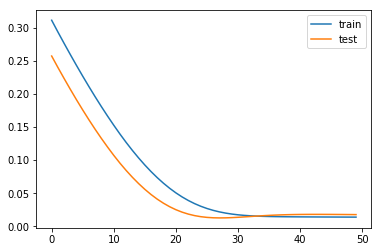

In [30]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Visualization of the Model

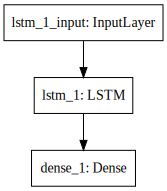

In [31]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [32]:
# Predict the next day's Close price (Y) for both training and test data
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)

## Convert data back to its original format

Example output shape

train_X.shape trainPredict.shape

(352, 1, 5)    (352, 1)


In [33]:
train_X.reshape(len(train_X),train_X.shape[2]).shape

(267, 6)

## Reshape

In [34]:
def reshape_to_orig(x,y):
    '''
    Merging x and y into its original series shape.
    
    Reshape x from (rows_count,1,cols_count) => (rows_count,cols_count) 
    and concat with y in the shape (rows_count,1)
    For example: (88, 1, 5) + (88, 1) => (88,6)
    
    '''
    return np.hstack((x.reshape(len(x),x.shape[2]), y))

In [35]:
# Calling reshape_to_orig function to reshape both the training aand test data
trainPredict2 = reshape_to_orig(train_X,trainPredict)
trainY2 = reshape_to_orig(train_X,train_y)

testPredict2 = reshape_to_orig(test_X,testPredict)
testY2 = reshape_to_orig(test_X,test_y)

print(trainPredict2.shape, trainY2.shape)
print(testPredict2.shape, testY2.shape)
print(trainPredict2[:3])
print(trainPredict[:3,-1])

(267, 7) (267, 7)
(144, 7) (144, 7)
[[ 0.71818182  0.          0.27691166  0.36145958  0.3164547   0.43378838
   0.45822749]
 [ 0.71818182  0.          0.27691166  0.36145958  0.25724921  0.42621432
   0.45381075]
 [ 0.71818182  0.          0.27691166  0.36145958  0.18911888  0.41013262
   0.44741839]]
[ 0.45822749  0.45381075  0.44741839]


## Invert the scaling

In [36]:
# We have normalized/scaled our data before feeding into the model
# Now time to transform it back to the original matrix

trainPredict_orig = scaler.inverse_transform(trainPredict2)
trainY_orig = scaler.inverse_transform(trainY2)

testPredict_orig = scaler.inverse_transform(testPredict2)
testY_orig = scaler.inverse_transform(testY2)


'''
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY_orig[:,-1], trainPredict_orig[:,-1]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY_orig[:,-1], testPredict_orig[:,-1]))
print('Test Score: %.3f RMSE' % (testScore))

'''

print(trainPredict_orig.shape, trainY_orig.shape)
print(testPredict_orig.shape, testY_orig.shape)
print(trainPredict_orig[:4])
print(trainY_orig[:4])

(267, 7) (267, 7)
(144, 7) (144, 7)
[[  1.87000000e-01  -4.34360000e+00  -4.50000000e+02  -5.80500000e+03
    2.12830000e+08   1.17343203e+04  -4.52406509e+02]
 [  1.87000000e-01  -4.34360000e+00  -4.50000000e+02  -5.80500000e+03
    1.82832000e+08   1.16467219e+04  -4.61856879e+02]
 [  1.87000000e-01  -4.34360000e+00  -4.50000000e+02  -5.80500000e+03
    1.48312000e+08   1.14607277e+04  -4.75534444e+02]
 [  1.87000000e-01  -4.34360000e+00  -4.50000000e+02  -5.80500000e+03
    1.41010000e+08   1.15121539e+04  -4.75483558e+02]]
[[  1.87000000e-01  -4.34360000e+00  -4.50000000e+02  -5.80500000e+03
    2.12830000e+08   1.17343203e+04  -8.75984368e+01]
 [  1.87000000e-01  -4.34360000e+00  -4.50000000e+02  -5.80500000e+03
    1.82832000e+08   1.16467219e+04  -1.85994141e+02]
 [  1.87000000e-01  -4.34360000e+00  -4.50000000e+02  -5.80500000e+03
    1.48312000e+08   1.14607277e+04   5.14261720e+01]
 [  1.87000000e-01  -4.34360000e+00  -4.50000000e+02  -5.80500000e+03
    1.41010000e+08   1.15

## Invert the stationary data back to the original data format

In [37]:
df.info()
type(df_Y)
df_Y.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 411 entries, 2008-08-10 to 2016-06-19
Freq: W-SUN
Data columns (total 7 columns):
CPI            411 non-null float64
IPI            411 non-null float64
NFP            411 non-null int64
RetailSales    411 non-null int64
Volume         411 non-null float64
Close          411 non-null float64
Y-diff         411 non-null float64
dtypes: float64(5), int64(2)
memory usage: 45.7 KB


(412,)

In [38]:
# Add the diff with the Close price
train_inv = trainPredict_orig[:,-2] + trainPredict_orig[:,-1]
test_inv = testPredict_orig[:,-2] + testPredict_orig[:,-1]

df_plot = df
df_plot.info()
print(type(df_Y))
print(df_plot.shape, train_inv.shape, test_inv.shape,)
df_plot['Y'] = df_Y
#df_plot['Y_Predict'] = np.append(train_inv,test_inv)

#print(df_plot.tail(5))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 411 entries, 2008-08-10 to 2016-06-19
Freq: W-SUN
Data columns (total 7 columns):
CPI            411 non-null float64
IPI            411 non-null float64
NFP            411 non-null int64
RetailSales    411 non-null int64
Volume         411 non-null float64
Close          411 non-null float64
Y-diff         411 non-null float64
dtypes: float64(5), int64(2)
memory usage: 45.7 KB
<class 'pandas.core.series.Series'>
(411, 7) (267,) (144,)


In [39]:
df_plot['Y_Predict'] = np.append(train_inv,test_inv)

## Calculate the RMSE

In [40]:
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(df_plot['Y'][:train_size], df_plot['Y_Predict'][:train_size]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(df_plot['Y'][train_size:], df_plot['Y_Predict'][train_size:]))
print('Test Score: %.3f RMSE' % (testScore))

Train Score: 250.483 RMSE
Test Score: 283.520 RMSE


# Plotting the data
Plotting the train and test data vs the actual next day's Close price

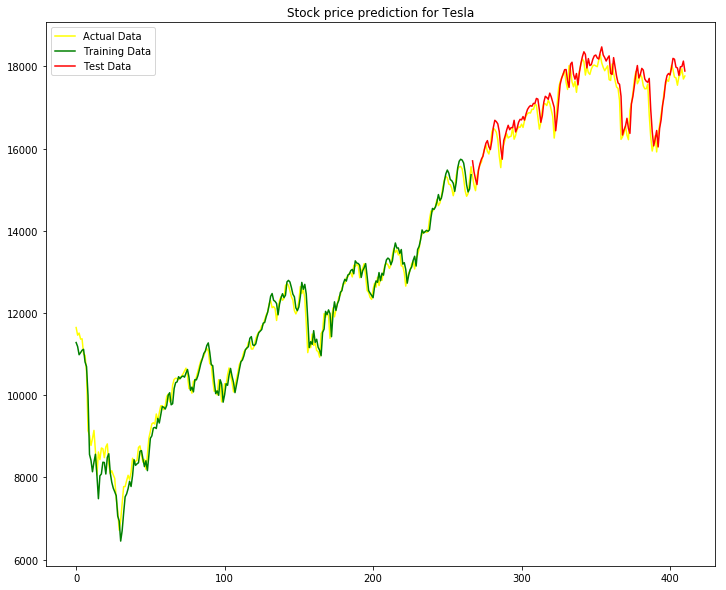

In [41]:

# The actual 'Close' price for next day - actual Y value
data_plot = data[:,-1].reshape(-1,1)

data_plot = df['Y'].values.reshape(-1,1)
#print(data_plot.shape)
#print(data_plot)

# Predicted Close price for the training data
train_plot = np.empty_like(data_plot)
train_plot[:,:] = np.nan
train_plot[:train_size,:] = df['Y_Predict'][:train_size].values.reshape(-1,1)

#train_plot = df['Y_Predict'][:train_size].values
#print(train_plot.shape)

test_plot = np.empty_like(data_plot)
test_plot[:,:] = np.nan
test_plot[train_size:,:] = df['Y_Predict'][train_size:].values.reshape(-1,1)

#test_plot = df['Y_Predict'][train_size:].values
#print(test_plot.shape)

plt.figure(figsize=(12,10))
plt.plot(data_plot, color='yellow', label='Actual Data')
plt.plot(train_plot, color='green', label='Training Data')
plt.plot(test_plot, color='red', label='Test Data')
plt.title('Stock price prediction for Dow Jones Index')
plt.legend()
plt.show()

In [42]:
# Actual data 

print(df_plot[['Y_Predict', 'Y']].tail(30))

               Y_Predict             Y
Date                                  
2015-11-29  17950.516824  17732.650000
2015-12-06  17907.901273  17526.154297
2015-12-13  17693.937405  17453.378125
2015-12-20  17636.339878  17455.916992
2015-12-27  17612.782637  17569.537110
2016-01-03  17707.898008  16814.931836
2016-01-10  16956.309691  16286.666211
2016-01-17  16421.250558  15939.737305
2016-01-24  16064.422169  16106.570117
2016-01-31  16232.000803  16312.185938
2016-02-07  16439.732421  15918.037891
2016-02-14  16039.614739  16363.915039
2016-02-21  16491.470195  16574.937890
2016-02-28  16698.909199  16846.314062
2016-03-06  17057.093641  17049.369922
2016-03-13  17266.868528  17378.042187
2016-03-20  17614.382740  17556.189942
2016-03-27  17776.880353  17672.600000
2016-04-03  17826.177550  17635.058594
2016-04-10  17789.433744  17801.966016
2016-04-17  17960.944142  18028.059765
2016-04-24  18194.280575  17922.702344
2016-05-01  18173.639985  17738.934375
2016-05-08  17979.791179 

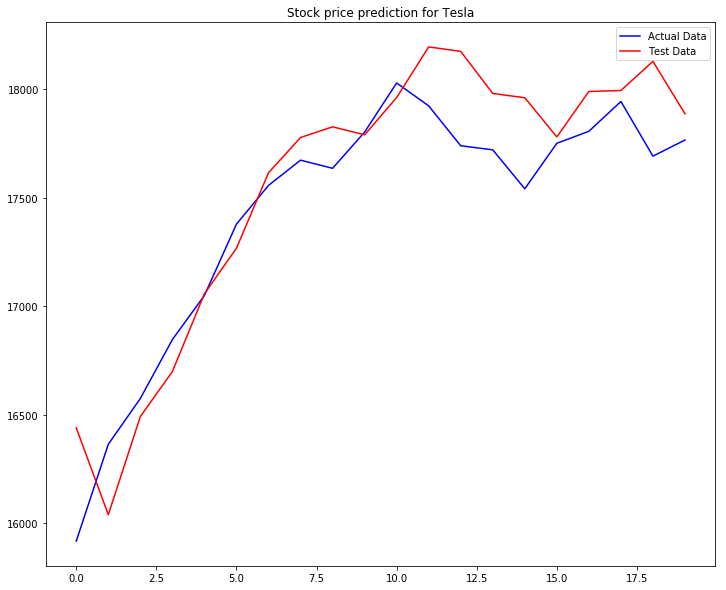

In [43]:
# This is to zoom into the last 60 days of the prediction
plt.figure(figsize=(12,10))
plt.plot(data_plot[-20:,-1], color='blue', label='Actual Data')
plt.plot(test_plot[-20:,-1], color='red', label='Test Data')
plt.title('Stock price prediction for Dow Jones Index')
plt.legend()
plt.show()